In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from shapely.geometry import Point
from shapely.geometry import shape

In [2]:
## ================================================== Station_Hour_BART_Data_Start ===========================================##

In [3]:
# add lat and lon info for station
ridership_data = pd.read_csv('202210-capitalbikeshare-tripdata.csv')
station_lat = gpd.GeoDataFrame(ridership_data.groupby('start_station_id').start_lat.mean()).reset_index()
station_lon = gpd.GeoDataFrame(ridership_data.groupby('start_station_id').start_lng.mean()).reset_index()
station_info = station_lat.merge(station_lon, how = 'left', on = 'start_station_id')
station_info['geometry'] = station_info[['start_lng', 'start_lat']].values.tolist()
station_info['geometry'] = station_info['geometry'].apply(Point)
station_info.head()

,start_station_id,start_lat,start_lng,geometry
0,31000.0,38.858965,-77.053239,POINT (-77.0532392695862 38.85896486951724)
1,31002.0,38.856413,-77.049233,POINT (-77.04923251291045 38.85641347925373)
2,31003.0,38.861048,-77.049414,POINT (-77.04941449783506 38.86104787675258)
3,31004.0,38.857867,-77.059489,POINT (-77.05948920176871 38.8578665737415)
4,31005.0,38.862293,-77.059936,POINT (-77.05993585821217 38.86229348622789)


In [4]:
# bike lane density
bike_density = gpd.read_file('Bicycle_Lanes.geojson')

# add a new attribute "LENGTH_M"
bike_density_len = gpd.GeoDataFrame({'geometry': bike_density.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
bike_density_len['TOTALBIKELANES'] = bike_density.TOTALBIKELANES
bike_density['LENGTH_M'] = bike_density_len.TOTALBIKELANES * bike_density_len.geometry.length

station_info['bike_density'] = station_info['start_lat']
dist_threshold = 1
bike_density_geo = gpd.GeoDataFrame({'geometry': bike_density.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
station_info_geo = gpd.GeoDataFrame({'geometry': station_info.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
for i in range (len(station_info_geo)):
    station_info['bike_density'].iloc[i] = np.sum(bike_density.LENGTH_M.loc[bike_density_geo.distance(station_info_geo.iloc[i].geometry)/1000 <= dist_threshold])
station_info['bike_density'] = station_info['bike_density']/max(station_info['bike_density'])
station_info.head()

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_20196\1680010822.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_info['bike_density'].iloc[i] = np.sum(bike_density.LENGTH_M.loc[bike_density_geo.distance(station_info_geo.iloc[i].geometry)/1000 <= dist_threshold])


,start_station_id,start_lat,start_lng,geometry,bike_density
0,31000.0,38.858965,-77.053239,POINT (-77.0532392695862 38.85896486951724),0.0
1,31002.0,38.856413,-77.049233,POINT (-77.04923251291045 38.85641347925373),0.0
2,31003.0,38.861048,-77.049414,POINT (-77.04941449783506 38.86104787675258),0.0
3,31004.0,38.857867,-77.059489,POINT (-77.05948920176871 38.8578665737415),0.0
4,31005.0,38.862293,-77.059936,POINT (-77.05993585821217 38.86229348622789),0.0


In [5]:
# distance to metro bus stop
metro_bus_stop = gpd.read_file('Metro_Bus_Stops.geojson')
station_info['dist_to_transit'] = station_info['start_lat']

metro_bus_stop_geo = gpd.GeoDataFrame({'geometry': metro_bus_stop.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
station_info_geo = gpd.GeoDataFrame({'geometry': station_info.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
for i in range (len(station_info_geo)):
    station_info['dist_to_transit'].iloc[i] = np.mean(np.sort(metro_bus_stop_geo.distance(station_info_geo.iloc[i].geometry)/1000)[0:5])
station_info.head()

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_20196\347111509.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_info['dist_to_transit'].iloc[i] = np.mean(np.sort(metro_bus_stop_geo.distance(station_info_geo.iloc[i].geometry)/1000)[0:5])


,start_station_id,start_lat,start_lng,geometry,bike_density,dist_to_transit
0,31000.0,38.858965,-77.053239,POINT (-77.0532392695862 38.85896486951724),0.0,0.155318
1,31002.0,38.856413,-77.049233,POINT (-77.04923251291045 38.85641347925373),0.0,0.185076
2,31003.0,38.861048,-77.049414,POINT (-77.04941449783506 38.86104787675258),0.0,0.379882
3,31004.0,38.857867,-77.059489,POINT (-77.05948920176871 38.8578665737415),0.0,0.333962
4,31005.0,38.862293,-77.059936,POINT (-77.05993585821217 38.86229348622789),0.0,0.089976


In [6]:
## ================================================== Station_Hour_Data_Start ================================================##

In [7]:
BART_data = pd.read_csv('BART_data.csv')
BART_data = BART_data.loc[(BART_data['end_station_id'].isin(BART_data.start_station_id.unique()))]
BART_data.travel_time.loc[(BART_data['travel_time'] > 120)] = 120
BART_data = BART_data.drop(columns = 'bike_density')
BART_data.head()

,start_station_id,end_station_id,day,hour,travel_time,travel_distance,rideable_type,member_casual,point,TRACTCE,pop_den,male_ratio,housing_unit_den,LU_diversity
0,31203.0,31275.0,19,20,6.0,1.867580,0,1,POINT (-77.03230400000911 38.9085978830601),5203,0.026697,0.376103,0.027061,1.891088
1,31295.0,31212.0,25,21,8.0,1.626852,2,1,POINT (-77.06524196954783 38.90551136242609),202,0.005131,0.431476,0.002424,2.428084
2,31203.0,31239.0,20,18,4.0,0.744880,2,1,POINT (-77.03230400000911 38.9085978830601),5203,0.026697,0.376103,0.027061,1.891088
3,31203.0,31669.0,29,0,28.0,4.593907,2,1,POINT (-77.03230400000911 38.9085978830601),5203,0.026697,0.376103,0.027061,1.891088
4,31203.0,31239.0,11,18,5.0,0.744880,2,1,POINT (-77.03230400000911 38.9085978830601),5203,0.026697,0.376103,0.027061,1.891088


In [8]:
## start
station_hour_data_start = pd.DataFrame(BART_data.groupby(['start_station_id', 'hour'])['travel_time', 'travel_distance', 'rideable_type', 'member_casual', 'pop_den', 'male_ratio', 'housing_unit_den', 'LU_diversity'].mean()).reset_index()
station_hour_ridership_start = pd.DataFrame(BART_data[['start_station_id', 'hour']].value_counts()).reset_index()
station_hour_data_start['ridership'] = station_hour_ridership_start.iloc[:,[2]]
station_hour_data_start = station_hour_data_start.merge(station_info, how='left', on='start_station_id')
station_hour_data_start.head()

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_20196\158584317.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  station_hour_data_start = pd.DataFrame(BART_data.groupby(['start_station_id', 'hour'])['travel_time', 'travel_distance', 'rideable_type', 'member_casual', 'pop_den', 'male_ratio', 'housing_unit_den', 'LU_diversity'].mean()).reset_index()


,start_station_id,hour,travel_time,travel_distance,rideable_type,member_casual,pop_den,male_ratio,housing_unit_den,LU_diversity,ridership,start_lat,start_lng,geometry,bike_density,dist_to_transit
0,31100.0,0,8.000000,1.498684,2.000000,1.000000,0.001615,0.467361,0.00153,1.410208,471,38.900289,-77.042902,POINT (-77.04290151498334 38.90028851636666),0.609622,0.119013
1,31100.0,2,15.000000,3.632470,2.000000,0.000000,0.001615,0.467361,0.00153,1.410208,405,38.900289,-77.042902,POINT (-77.04290151498334 38.90028851636666),0.609622,0.119013
2,31100.0,7,8.000000,1.339926,2.000000,1.000000,0.001615,0.467361,0.00153,1.410208,390,38.900289,-77.042902,POINT (-77.04290151498334 38.90028851636666),0.609622,0.119013
3,31100.0,8,12.777778,1.935379,1.333333,0.666667,0.001615,0.467361,0.00153,1.410208,383,38.900289,-77.042902,POINT (-77.04290151498334 38.90028851636666),0.609622,0.119013
4,31100.0,9,25.434783,1.166906,1.913043,0.347826,0.001615,0.467361,0.00153,1.410208,372,38.900289,-77.042902,POINT (-77.04290151498334 38.90028851636666),0.609622,0.119013


In [9]:
## ================================================== Station_Hour_Data_End ================================================##

In [10]:
## capture the time of end_station_id
ridership_data = pd.read_csv('202210-capitalbikeshare-tripdata.csv')
ridership_data.start_station_id = ridership_data.start_station_id.fillna(0.0)
ridership_data.end_station_id = ridership_data.end_station_id.fillna(0.0)
ridership_data = ridership_data.loc[(ridership_data['start_station_id'] != 0) & (ridership_data['end_station_id'] != 0)]
ridership_data['day'] = pd.to_datetime(ridership_data.ended_at).dt.day
ridership_data['hour'] = pd.to_datetime(ridership_data.ended_at).dt.hour
ridership_data = ridership_data.loc[(ridership_data['start_station_id'].isin(BART_data.start_station_id.unique()) & ridership_data['end_station_id'].isin(BART_data.start_station_id.unique()))]
ridership_data.reset_index(drop = True, inplace = True)
ridership_data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,day,hour
0,88E008078B2E7FFC,electric_bike,10/19/2022 20:16,10/19/2022 20:22,14th & Rhode Island Ave NW,31203.0,New Hampshire Ave & 24th St NW,31275.0,38.908675,-77.032505,38.901755,-77.051084,member,19,20
1,53D58D1427BF475B,classic_bike,10/25/2022 21:10,10/25/2022 21:18,Potomac & M St NW,31295.0,New Hampshire Ave & Ward Pl NW,31212.0,38.905509,-77.065246,38.905711,-77.047318,member,25,21
2,69247684F27CAB16,classic_bike,10/20/2022 18:07,10/20/2022 18:11,14th & Rhode Island Ave NW,31203.0,Rhode Island & Connecticut Ave NW,31239.0,38.908600,-77.032300,38.905996,-77.039802,member,20,18
3,021E310139F2FFE4,classic_bike,10/29/2022 0:36,10/29/2022 1:04,14th & Rhode Island Ave NW,31203.0,3rd & M St SE,31669.0,38.908600,-77.032300,38.876823,-77.002161,member,29,1
4,04A3B5CBCF7DD67A,classic_bike,10/11/2022 18:07,10/11/2022 18:12,14th & Rhode Island Ave NW,31203.0,Rhode Island & Connecticut Ave NW,31239.0,38.908600,-77.032300,38.905996,-77.039802,member,11,18


In [11]:
BART_data_end = BART_data.copy()
BART_data_end['day'] = ridership_data['day']
BART_data_end['hour'] = ridership_data['hour']
BART_data_end.head()

,start_station_id,end_station_id,day,hour,travel_time,travel_distance,rideable_type,member_casual,point,TRACTCE,pop_den,male_ratio,housing_unit_den,LU_diversity
0,31203.0,31275.0,19.0,20.0,6.0,1.867580,0,1,POINT (-77.03230400000911 38.9085978830601),5203,0.026697,0.376103,0.027061,1.891088
1,31295.0,31212.0,25.0,21.0,8.0,1.626852,2,1,POINT (-77.06524196954783 38.90551136242609),202,0.005131,0.431476,0.002424,2.428084
2,31203.0,31239.0,20.0,18.0,4.0,0.744880,2,1,POINT (-77.03230400000911 38.9085978830601),5203,0.026697,0.376103,0.027061,1.891088
3,31203.0,31669.0,29.0,1.0,28.0,4.593907,2,1,POINT (-77.03230400000911 38.9085978830601),5203,0.026697,0.376103,0.027061,1.891088
4,31203.0,31239.0,11.0,18.0,5.0,0.744880,2,1,POINT (-77.03230400000911 38.9085978830601),5203,0.026697,0.376103,0.027061,1.891088


In [12]:
## end
station_info_end = station_info.copy()
station_info_end = station_info_end.rename(columns = {'start_station_id': 'end_station_id'})
station_hour_data_end = pd.DataFrame(BART_data_end.groupby(['end_station_id', 'hour'])['travel_time', 'travel_distance', 'rideable_type', 'member_casual'].mean()).reset_index()
station_hour_ridership_end = pd.DataFrame(BART_data_end[['end_station_id', 'hour']].value_counts()).reset_index()
station_hour_data_end['ridership'] = station_hour_ridership_end.iloc[:,[2]]
station_hour_data_end = station_hour_data_end.merge(station_info_end, how='left', on='end_station_id')
station_attribute_BART = pd.DataFrame(BART_data_end.groupby('start_station_id')['pop_den', 'male_ratio', 'housing_unit_den', 'LU_diversity'].mean()).reset_index()
station_attribute_BART = station_attribute_BART.rename(columns = {'start_station_id': 'end_station_id'})
station_hour_data_end = station_hour_data_end.merge(station_attribute_BART, how='left', on='end_station_id')
station_hour_data_end.head()

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_20196\1932759476.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  station_hour_data_end = pd.DataFrame(BART_data_end.groupby(['end_station_id', 'hour'])['travel_time', 'travel_distance', 'rideable_type', 'member_casual'].mean()).reset_index()
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_20196\1932759476.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  station_attribute_BART = pd.DataFrame(BART_data_end.groupby('start_station_id')['pop_den', 'male_ratio', 'housing_unit_den', 'LU_diversity'].mean()).reset_index()


,end_station_id,hour,travel_time,travel_distance,rideable_type,member_casual,ridership,start_lat,start_lng,geometry,bike_density,dist_to_transit,pop_den,male_ratio,housing_unit_den,LU_diversity
0,31100.0,0.0,8.00,1.543140,2.0,1.0,418,38.900289,-77.042902,POINT (-77.04290151498334 38.90028851636666),0.609622,0.119013,0.001615,0.467361,0.00153,1.410208
1,31100.0,1.0,12.75,1.978144,1.5,0.0,396,38.900289,-77.042902,POINT (-77.04290151498334 38.90028851636666),0.609622,0.119013,0.001615,0.467361,0.00153,1.410208
2,31100.0,2.0,11.50,1.787551,2.0,0.5,373,38.900289,-77.042902,POINT (-77.04290151498334 38.90028851636666),0.609622,0.119013,0.001615,0.467361,0.00153,1.410208
3,31100.0,5.0,16.00,2.798437,2.0,1.0,367,38.900289,-77.042902,POINT (-77.04290151498334 38.90028851636666),0.609622,0.119013,0.001615,0.467361,0.00153,1.410208
4,31100.0,6.0,9.80,1.426106,1.6,0.4,351,38.900289,-77.042902,POINT (-77.04290151498334 38.90028851636666),0.609622,0.119013,0.001615,0.467361,0.00153,1.410208


In [13]:
## ================================================= Station_Full_Hour_BART_Data =============================================##

In [14]:
# start
station_attribute_BART_start = pd.DataFrame(station_hour_data_start.groupby('start_station_id')['pop_den', 'male_ratio', 'housing_unit_den', 'LU_diversity', 'bike_density', 'dist_to_transit', 'start_lat', 'start_lng'].mean()).reset_index()
station_24_hour_data_start = pd.concat([station_attribute_BART_start]*24, ignore_index=True)
station_24_hour_data_start['hour'] = np.array(station_24_hour_data_start.index/len(station_attribute_BART_start)).astype(int)
station_24_hour_data_start = station_24_hour_data_start.merge(station_hour_data_start[['start_station_id','hour','travel_time','travel_distance','rideable_type','member_casual','ridership']], how='left',on=['start_station_id','hour'])
station_24_hour_data_start = station_24_hour_data_start.fillna(0)
#station_24_hour_data_start.to_csv('station_24_hour_data_start.csv', index = False)
station_24_hour_data_start.head()

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_20196\4219154875.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  station_attribute_BART_start = pd.DataFrame(station_hour_data_start.groupby('start_station_id')['pop_den', 'male_ratio', 'housing_unit_den', 'LU_diversity', 'bike_density', 'dist_to_transit', 'start_lat', 'start_lng'].mean()).reset_index()


,start_station_id,pop_den,male_ratio,housing_unit_den,LU_diversity,bike_density,dist_to_transit,start_lat,start_lng,hour,travel_time,travel_distance,rideable_type,member_casual,ridership
0,31100.0,0.001615,0.467361,0.001530,1.410208,0.609622,0.119013,38.900289,-77.042902,0,8.000000,1.498684,2.000000,1.000000,471.0
1,31101.0,0.014014,0.440458,0.010089,2.515274,0.744222,0.104408,38.917766,-77.032083,0,13.256410,1.606589,1.948718,0.589744,299.0
2,31102.0,0.013170,0.409156,0.007601,1.914395,0.407969,0.102056,38.929463,-77.027821,0,9.394737,1.675560,1.736842,0.526316,245.0
3,31104.0,0.017918,0.405918,0.014953,2.041013,0.527567,0.072620,38.922865,-77.042517,0,11.936170,1.530526,1.702128,0.638298,210.0
4,31105.0,0.013170,0.409156,0.007601,1.914395,0.453681,0.135561,38.926792,-77.032203,0,10.000000,1.744685,1.500000,0.625000,198.0


In [15]:
# end
station_attribute_BART_end = pd.DataFrame(station_hour_data_end.groupby('end_station_id')['pop_den', 'male_ratio', 'housing_unit_den', 'LU_diversity', 'bike_density', 'dist_to_transit', 'start_lat', 'start_lng'].mean()).reset_index()
station_24_hour_data_end = pd.concat([station_attribute_BART_end]*24, ignore_index=True)
station_24_hour_data_end['hour'] = np.array(station_24_hour_data_end.index/len(station_attribute_BART_end)).astype(int)
station_24_hour_data_end = station_24_hour_data_end.merge(station_hour_data_end[['end_station_id','hour','travel_time','travel_distance','rideable_type','member_casual','ridership']], how='left',on=['end_station_id','hour'])
station_24_hour_data_end = station_24_hour_data_end.fillna(0)
#station_24_hour_data_end.to_csv('station_24_hour_data_end.csv', index = False)
station_24_hour_data_end.head()

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_20196\3848004084.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  station_attribute_BART_end = pd.DataFrame(station_hour_data_end.groupby('end_station_id')['pop_den', 'male_ratio', 'housing_unit_den', 'LU_diversity', 'bike_density', 'dist_to_transit', 'start_lat', 'start_lng'].mean()).reset_index()


,end_station_id,pop_den,male_ratio,housing_unit_den,LU_diversity,bike_density,dist_to_transit,start_lat,start_lng,hour,travel_time,travel_distance,rideable_type,member_casual,ridership
0,31100.0,0.001615,0.467361,0.001530,1.410208,0.609622,0.119013,38.900289,-77.042902,0,8.000000,1.543140,2.000000,1.000000,418.0
1,31101.0,0.014014,0.440458,0.010089,2.515274,0.744222,0.104408,38.917766,-77.032083,0,10.037037,1.546378,1.888889,0.703704,255.0
2,31102.0,0.013170,0.409156,0.007601,1.914395,0.407969,0.102056,38.929463,-77.027821,0,11.625000,1.866259,1.750000,0.500000,221.0
3,31104.0,0.017918,0.405918,0.014953,2.041013,0.527567,0.072620,38.922865,-77.042517,0,12.000000,1.925485,1.600000,0.600000,202.0
4,31105.0,0.013170,0.409156,0.007601,1.914395,0.453681,0.135561,38.926792,-77.032203,0,7.833333,1.213247,2.000000,0.500000,184.0


In [16]:
## ================================================= Frequency Distribution =============================================##

In [17]:
# diff
station_24_hour_data_diff = station_24_hour_data_start.copy()
station_24_hour_data_diff = station_24_hour_data_diff.rename(columns={'start_station_id': 'station_id'})
station_24_hour_data_diff['ridership'] = station_24_hour_data_end['ridership'] - station_24_hour_data_start['ridership']
station_24_hour_data_diff['housing_unit_den'] = station_24_hour_data_diff['housing_unit_den'] * 100
station_24_hour_data_diff['pop_den'] = station_24_hour_data_diff['pop_den'] * 100
#station_24_hour_data_diff.to_csv('station_24_hour_data_diff.csv', index = False)
station_24_hour_data_diff.head()

,station_id,pop_den,male_ratio,housing_unit_den,LU_diversity,bike_density,dist_to_transit,start_lat,start_lng,hour,travel_time,travel_distance,rideable_type,member_casual,ridership
0,31100.0,0.161510,0.467361,0.152985,1.410208,0.609622,0.119013,38.900289,-77.042902,0,8.000000,1.498684,2.000000,1.000000,-53.0
1,31101.0,1.401387,0.440458,1.008898,2.515274,0.744222,0.104408,38.917766,-77.032083,0,13.256410,1.606589,1.948718,0.589744,-44.0
2,31102.0,1.316964,0.409156,0.760079,1.914395,0.407969,0.102056,38.929463,-77.027821,0,9.394737,1.675560,1.736842,0.526316,-24.0
3,31104.0,1.791824,0.405918,1.495257,2.041013,0.527567,0.072620,38.922865,-77.042517,0,11.936170,1.530526,1.702128,0.638298,-8.0
4,31105.0,1.316964,0.409156,0.760079,1.914395,0.453681,0.135561,38.926792,-77.032203,0,10.000000,1.744685,1.500000,0.625000,-14.0


D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\geopandas\geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


Text(0.5, 1.0, 'Station-level net demand (Rental-Retrun)')

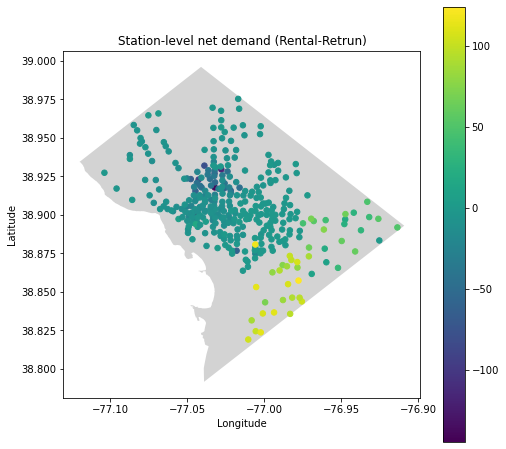

In [18]:
# for gis visualization
from mpl_toolkits.axes_grid1 import make_axes_locatable
station_hour_data_diff = gpd.GeoDataFrame(station_24_hour_data_diff[['station_id', 'start_lat', 'start_lng', 'ridership']].groupby('station_id').mean().reset_index())
#station_hour_data_diff.to_csv('station_hour_data_diff.csv', index=False)
station_hour_data_diff['geometry'] = station_hour_data_diff[[ 'start_lng', 'start_lat']].values.tolist()
station_hour_data_diff['geometry'] = station_hour_data_diff['geometry'].apply(Point)
fig, ax = plt.subplots(1, figsize=(8,8))
divider = make_axes_locatable(ax)
#bicycle_lane = gpd.read_file('Bicycle_Lanes.geojson')
#base2 =bicycle_lane.plot(ax=ax, color='#e32636')
washington_DC_boundary = gpd.read_file('Washington_DC_Boundary.geojson')
base2 =washington_DC_boundary.plot(ax=ax, color='#d3d3d3')
station_hour_data_diff.plot(column='ridership', ax=ax, markersize=30,  legend=True) # Plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Station-level net demand (Rental-Retrun)')

D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Sample size: n=8424')

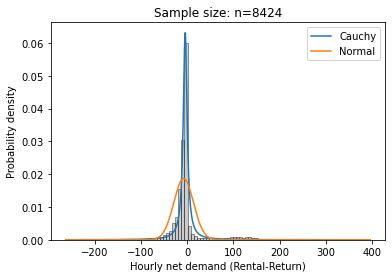

In [19]:
import seaborn as sns
from scipy import stats

fit_mu, fit_sigma=stats.norm.fit(station_24_hour_data_diff['ridership'].loc[abs(station_24_hour_data_diff['ridership']) <100])
norm_pdf=stats.norm.pdf(np.sort(station_24_hour_data_diff['ridership']),fit_mu, fit_sigma)

fit_mu, fit_sigma=stats.cauchy.fit(station_24_hour_data_diff['ridership'].loc[abs(station_24_hour_data_diff['ridership']) <100])
cauchy_pdf=stats.cauchy.pdf(np.sort(station_24_hour_data_diff['ridership']),fit_mu, fit_sigma)

sns.distplot(a=station_24_hour_data_diff['ridership'], kde = False, bins=100, norm_hist = True, color='grey',
             hist_kws={"edgecolor": 'black'})
plt.plot(np.sort(station_24_hour_data_diff['ridership']),cauchy_pdf)
plt.plot(np.sort(station_24_hour_data_diff['ridership']),norm_pdf)
plt.legend(['Cauchy','Normal'])
plt.xlabel('Hourly net demand (Rental-Return)')
plt.ylabel('Probability density')
plt.title('Sample size: n=8424')

Text(0, 0.5, 'Hourly net demand (Rental - Return)')

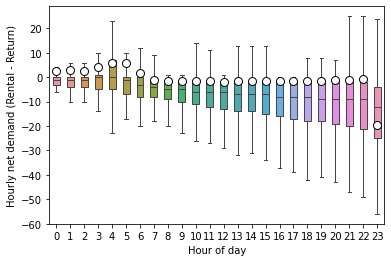

In [20]:
sns.boxplot(x="hour", y="ridership", data=station_24_hour_data_diff,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            flierprops = dict(marker='D', markersize=3),
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"},
           showfliers = False)
plt.xlabel("Hour of day")
plt.ylabel("Hourly net demand (Rental - Return)")

D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Probability density')

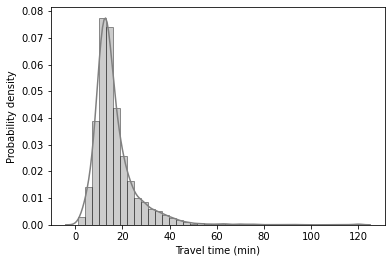

In [21]:
## travel time distribution
sns.distplot(a=station_24_hour_data_diff['travel_time'].loc[station_24_hour_data_diff['travel_time'] != 0], kde = True, bins=40, norm_hist = True, color='grey',
             hist_kws={"edgecolor": 'black'})
plt.xlabel('Travel time (min)')
plt.ylabel('Probability density')

D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Probability density')

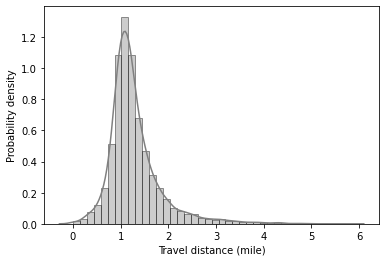

In [22]:
## travel distance distribution
sns.distplot(a=station_24_hour_data_diff['travel_distance'].loc[station_24_hour_data_diff['travel_distance'] != 0]*0.6214, kde = True, bins=40, norm_hist = True, color='grey',
             hist_kws={"edgecolor": 'black'})
plt.xlabel('Travel distance (mile)')
plt.ylabel('Probability density')

In [23]:
## descriptive staistics
station_24_hour_data_diff[['male_ratio','pop_den','housing_unit_den','LU_diversity','bike_density','rideable_type','member_casual','dist_to_transit','travel_time','travel_distance']].describe()

,male_ratio,pop_den,housing_unit_den,LU_diversity,bike_density,rideable_type,member_casual,dist_to_transit,travel_time,travel_distance
count,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000
mean,0.499828,0.554635,0.362660,1.946142,0.394813,1.484757,0.519847,0.172433,13.956629,1.739117
std,0.142647,0.453687,0.370967,0.434684,0.279059,0.706032,0.324067,0.113224,10.823428,1.115721
min,0.293966,0.000200,0.000000,0.610679,0.000000,0.000000,0.000000,0.037322,0.000000,0.000000
25%,0.429979,0.239272,0.151256,1.620035,0.153486,1.500000,0.270203,0.108874,9.000000,1.315255
50%,0.469341,0.401275,0.241005,1.928141,0.354657,1.800000,0.607143,0.141033,13.000000,1.759120
75%,0.530026,0.815286,0.449990,2.248437,0.609746,1.937500,0.750000,0.200539,17.666667,2.217793
max,1.000000,2.669692,2.706088,2.809673,1.000000,2.000000,1.000000,0.991380,120.000000,9.355520


In [24]:
station_24_hour_data_diff.describe()

,station_id,pop_den,male_ratio,housing_unit_den,LU_diversity,bike_density,dist_to_transit,start_lat,start_lng,hour,travel_time,travel_distance,rideable_type,member_casual,ridership
count,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8424.000000,8376.000000
mean,31431.615385,0.554635,0.499828,0.362660,1.946142,0.394813,0.172433,38.904320,-77.018236,11.500000,13.956629,1.739117,1.484757,0.519847,-0.653653
std,215.608078,0.453687,0.142647,0.370967,0.434684,0.279059,0.113224,0.026066,0.031256,6.922597,10.823428,1.115721,0.706032,0.324067,46.692263
min,31100.000000,0.000200,0.293966,0.000000,0.610679,0.000000,0.037322,38.819090,-77.103666,0.000000,0.000000,0.000000,0.000000,0.000000,-263.000000
25%,31250.000000,0.239272,0.429979,0.151256,1.620035,0.153486,0.108874,38.890455,-77.038555,5.750000,9.000000,1.315255,1.500000,0.270203,-13.000000
50%,31405.000000,0.401275,0.469341,0.241005,1.928141,0.354657,0.141033,38.902580,-77.021700,11.500000,13.000000,1.759120,1.800000,0.607143,-5.000000
75%,31634.000000,0.815286,0.530026,0.449990,2.248437,0.609746,0.200539,38.919019,-76.997222,17.250000,17.666667,2.217793,1.937500,0.750000,-1.000000
max,31828.000000,2.669692,1.000000,2.706088,2.809673,1.000000,0.991380,38.975219,-76.913580,23.000000,120.000000,9.355520,2.000000,1.000000,396.000000


In [25]:
## ========================================================= BART Model ===================================================##

In [26]:
## ======================================================= BART Model ================================================ ##
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

RANDOM_SEED = 5781
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

X = station_24_hour_data_diff[["hour", "pop_den", "male_ratio", "housing_unit_den", "LU_diversity", "bike_density","dist_to_transit", "travel_time", "travel_distance", "rideable_type", "member_casual"]]
Y = station_24_hour_data_diff["ridership"].fillna(0)

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [27]:
with pm.Model() as model_bikes:
    σ = pm.ChiSquared("σ", 3)
    ε = pm.HalfNormal("ε", abs(σ))
    μ = pmb.BART("μ", X, Y, m = 200)
    y = pm.Cauchy("y", μ, abs(ε), observed=Y)
    idata_bikes = pm.sample(random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ, ε]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 178100 seconds.


In [28]:
plt.rc('font', size=8) 

D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\arviz\plots\hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\arviz\plots\hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\arviz\plots\hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_

array([<AxesSubplot:xlabel='hour'>, <AxesSubplot:xlabel='pop_den'>,
       <AxesSubplot:xlabel='male_ratio'>,
       <AxesSubplot:xlabel='housing_unit_den'>,
       <AxesSubplot:xlabel='LU_diversity'>,
       <AxesSubplot:xlabel='bike_density'>,
       <AxesSubplot:xlabel='dist_to_transit'>,
       <AxesSubplot:xlabel='travel_time'>,
       <AxesSubplot:xlabel='travel_distance'>], dtype=object)

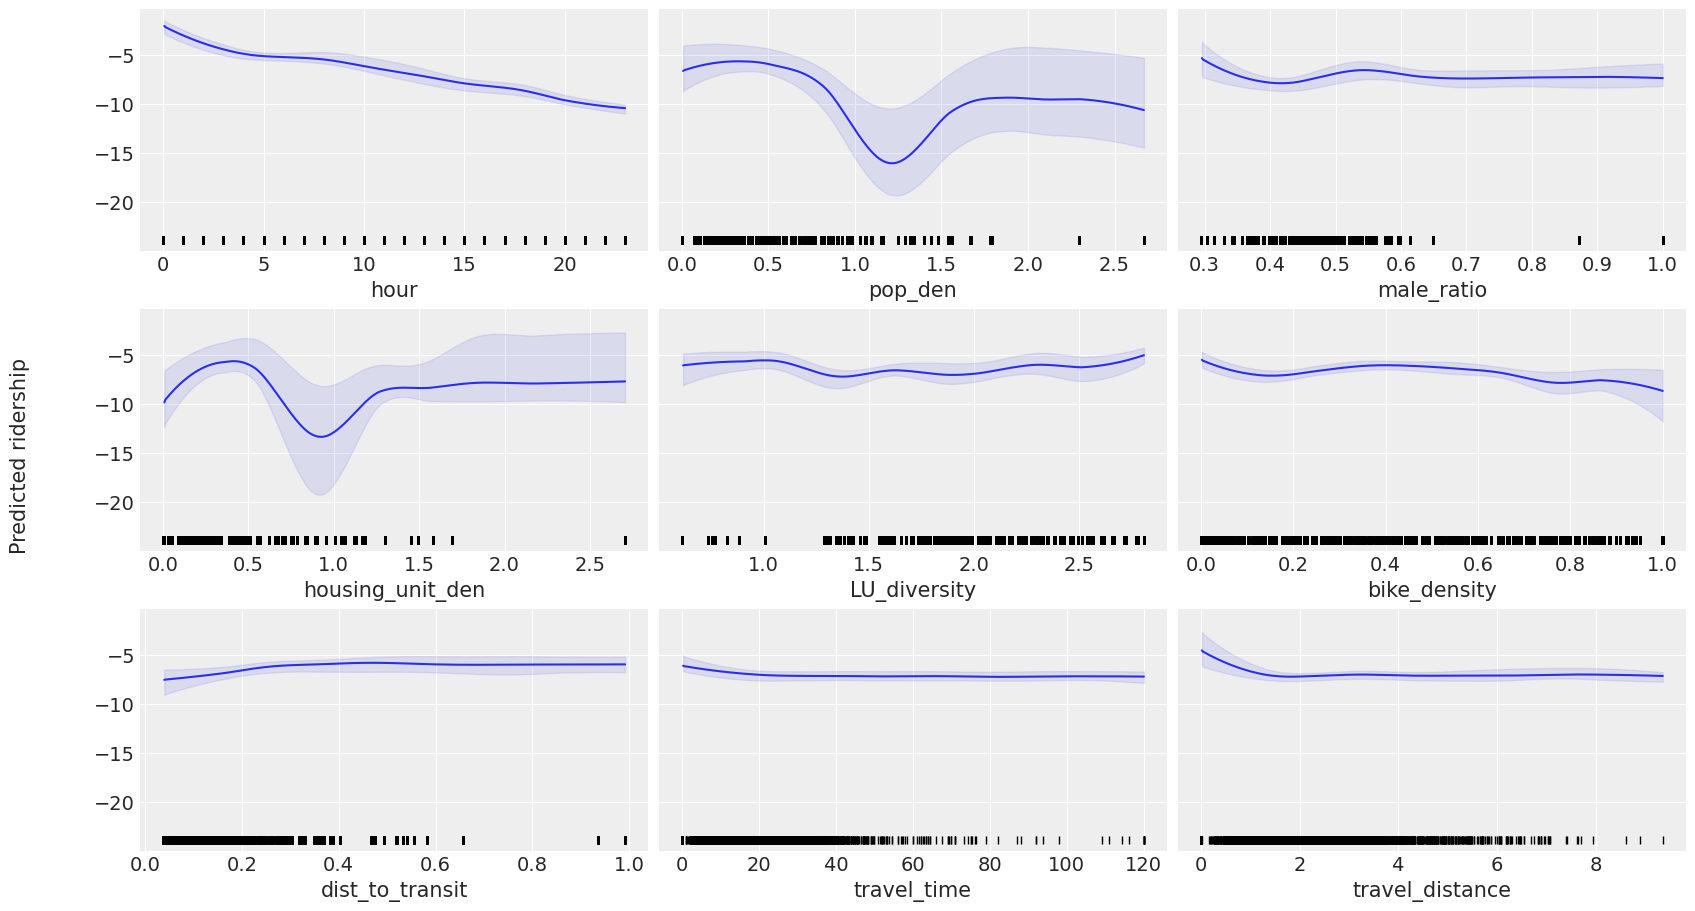

In [29]:
#plt.figure(figsize=(16,9))
pmb.plot_dependence(μ, X=X, Y=Y,grid=(3,3), figsize=(16,9))

In [30]:
plt.rc('font', size=8) 

array([<AxesSubplot:xlabel='hour'>, <AxesSubplot:xlabel='pop_den'>,
       <AxesSubplot:xlabel='male_ratio'>,
       <AxesSubplot:xlabel='housing_unit_den'>,
       <AxesSubplot:xlabel='LU_diversity'>,
       <AxesSubplot:xlabel='bike_density'>,
       <AxesSubplot:xlabel='dist_to_transit'>,
       <AxesSubplot:xlabel='travel_time'>,
       <AxesSubplot:xlabel='travel_distance'>], dtype=object)

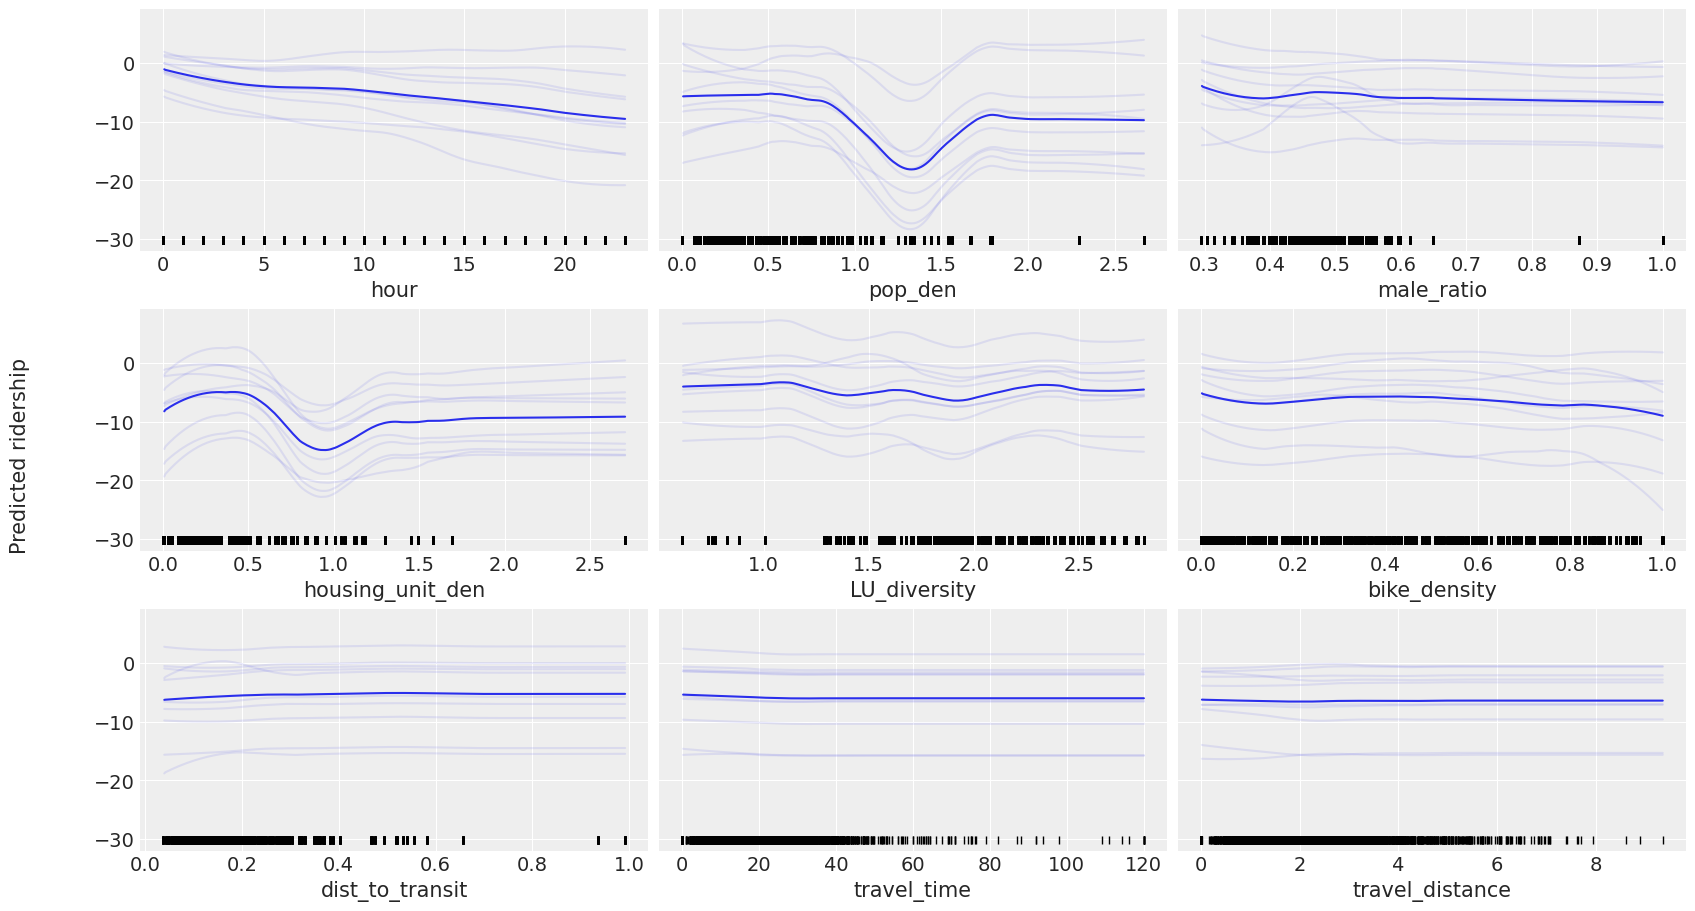

In [31]:
pmb.plot_dependence(μ, X=X, Y=Y, kind='ice', grid=(3,3), figsize=(16,9))

(array([-60., -40., -20.,   0.,  20.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

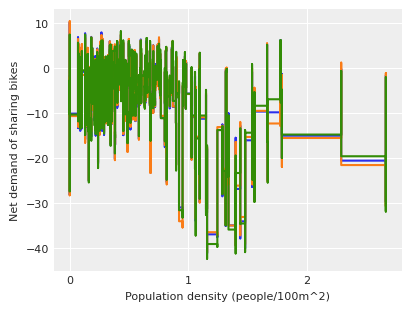

In [32]:
index = np.array(np.argsort(X["pop_den"]))
plt.figure(figsize=(4,3))
plt.step(np.sort(X["pop_den"]), idata_bikes.posterior["μ"].sel(chain=0, draw=[5,101,520])[:,index].T)
#plt.plot(np.sort(X["pop_den"]),Y[index])
plt.xlabel('Population density (people/100m^2)', fontsize = 8)
plt.ylabel("Net demand of sharing bikes", fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

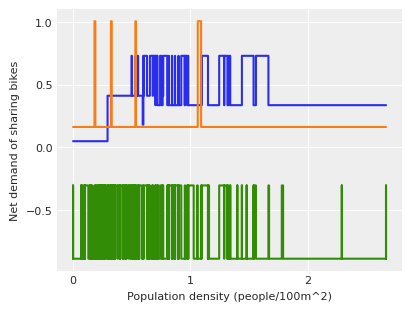

In [33]:
bart_trees = μ.owner.op.all_trees
plt.figure(figsize=(4,3))
for i in [0, 1, 2]:
    plt.step(np.sort(X["pop_den"]), [bart_trees[0][i].predict(X.iloc[j]) for j in np.array(np.argsort(X["pop_den"]))])
plt.xlabel('Population density (people/100m^2)', fontsize = 8)
plt.ylabel("Net demand of sharing bikes", fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

(array([ 1,  3,  0,  2,  4,  5,  9,  6,  8, 10,  7], dtype=int64),
 array([<AxesSubplot:xlabel='covariables', ylabel='importance'>,
        <AxesSubplot:xlabel='number of covariables', ylabel='R²'>],
       dtype=object))

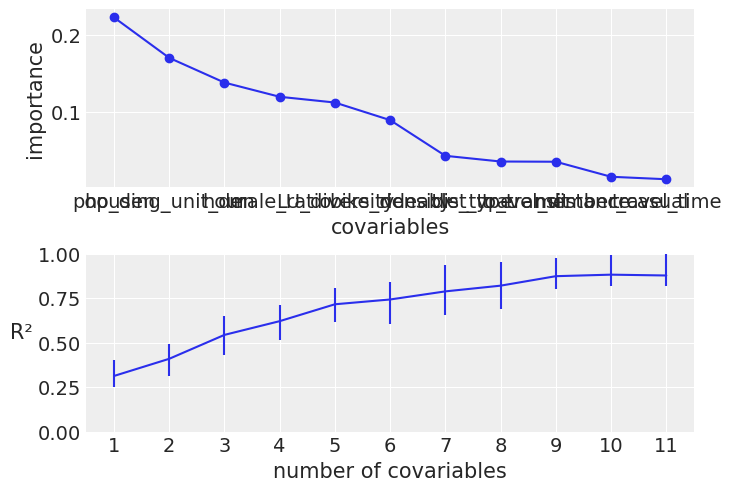

In [34]:
pmb.plot_variable_importance(idata_bikes, μ, X, samples=100)
# "pop_den", "housing_unit_den", "hour", "male_ratio", "LU_diversity", "bike_density", "rideable_type", "dist_to_transit", "travel_distance", "member_casual", "travel_time"

array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>],
       [<AxesSubplot:title={'center':'ε'}>,
        <AxesSubplot:title={'center':'ε'}>]], dtype=object)

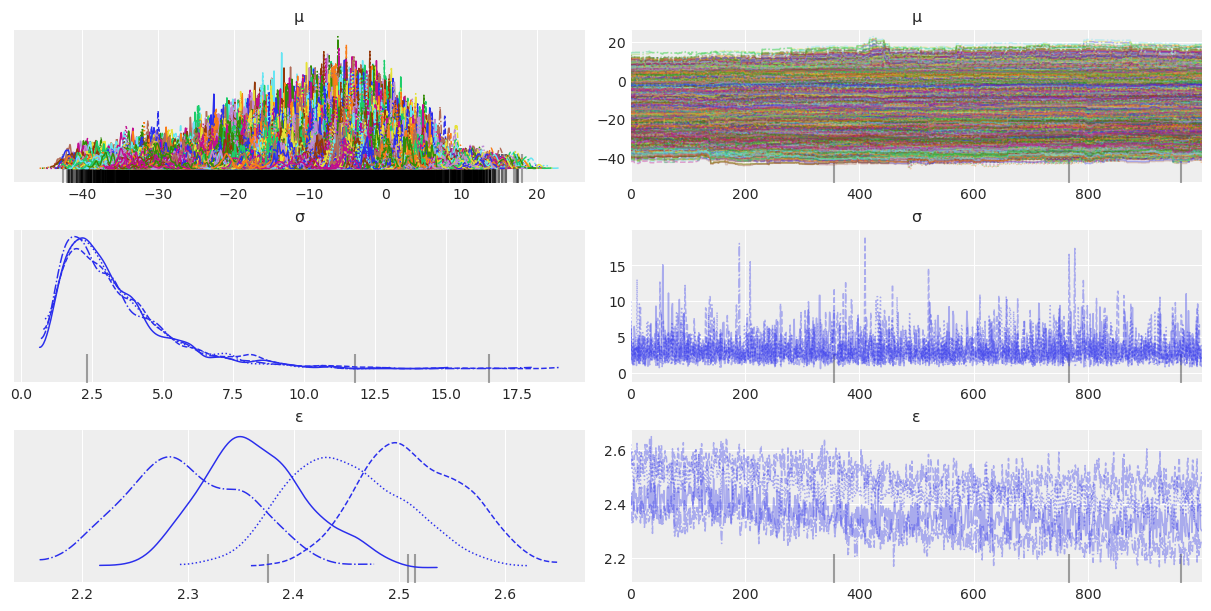

In [35]:
pm.plot_trace(idata_bikes)

Feature Ranking:
1. features 5 (0.291119)
2. features 0 (0.181847)
3. features 6 (0.098751)
4. features 1 (0.072373)
5. features 3 (0.070658)
6. features 4 (0.069266)
7. features 2 (0.065283)
8. features 7 (0.061883)
9. features 8 (0.061331)
10. features 10 (0.015573)
11. features 9 (0.011915)


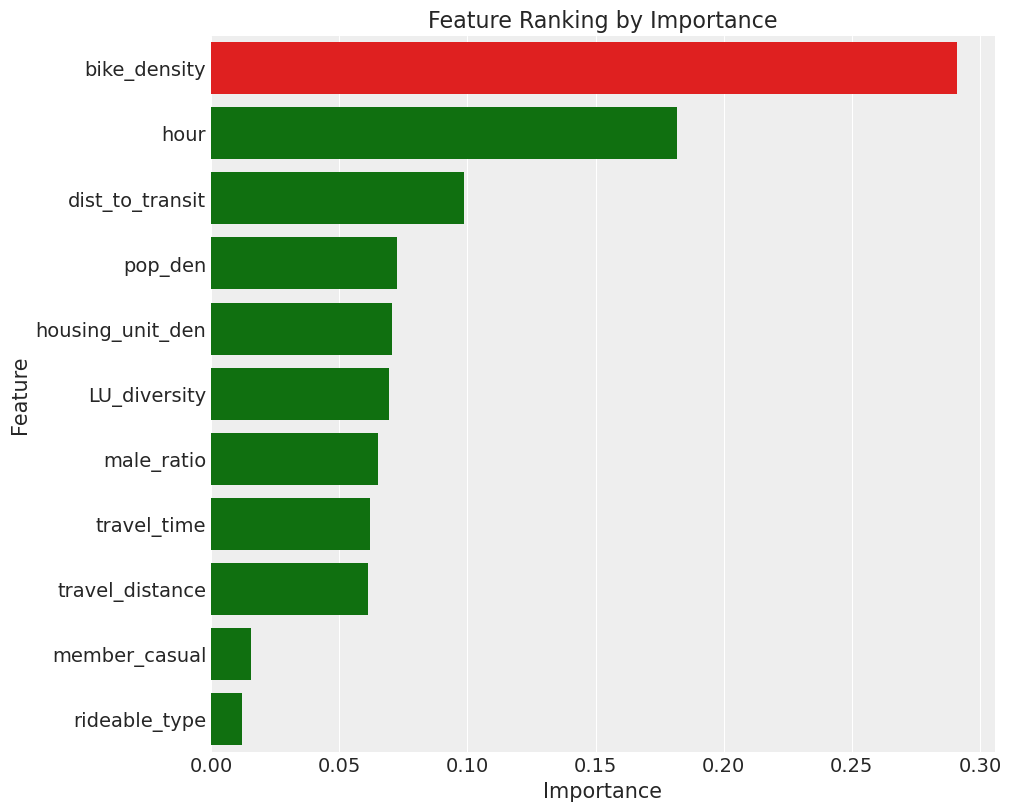

In [36]:
## Random Forest
# Feature selection based on random forest
from sklearn.ensemble import RandomForestRegressor as RRlf 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state=100)

RF_model = RRlf(n_estimators = 100)
RF_model.fit(X_train, y_train)
importances = RF_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_model.estimators_], axis = 0)

indices = np.argsort(importances)[::-1]

print('Feature Ranking:')
array_feature_RF = []
for f in range(X_train.shape[1]):
    print('%d. features %d (%f)'% (f+1, indices[f], importances[indices[f]]))
    array_feature_RF.append([X_train.columns[indices[f]], importances[indices[f]]])
array_feature_RF = np.array(array_feature_RF)
df_feature_RF = pd.DataFrame({'Feature': array_feature_RF[:, 0],
                             'Importance': array_feature_RF[:, 1]})

values = df_feature_RF.Importance.iloc[0:21]    
idx = df_feature_RF.Feature.iloc[0:21]  
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y = idx, x = values.astype('float'), palette = clrs).set(title = 'Feature Ranking by Importance')
plt.show()

Feature Importances :  [0.06693772 0.09338348 0.09283594 0.16771257 0.0903561  0.23428683
 0.08288534 0.04461197 0.0662854  0.03245643 0.02824816]


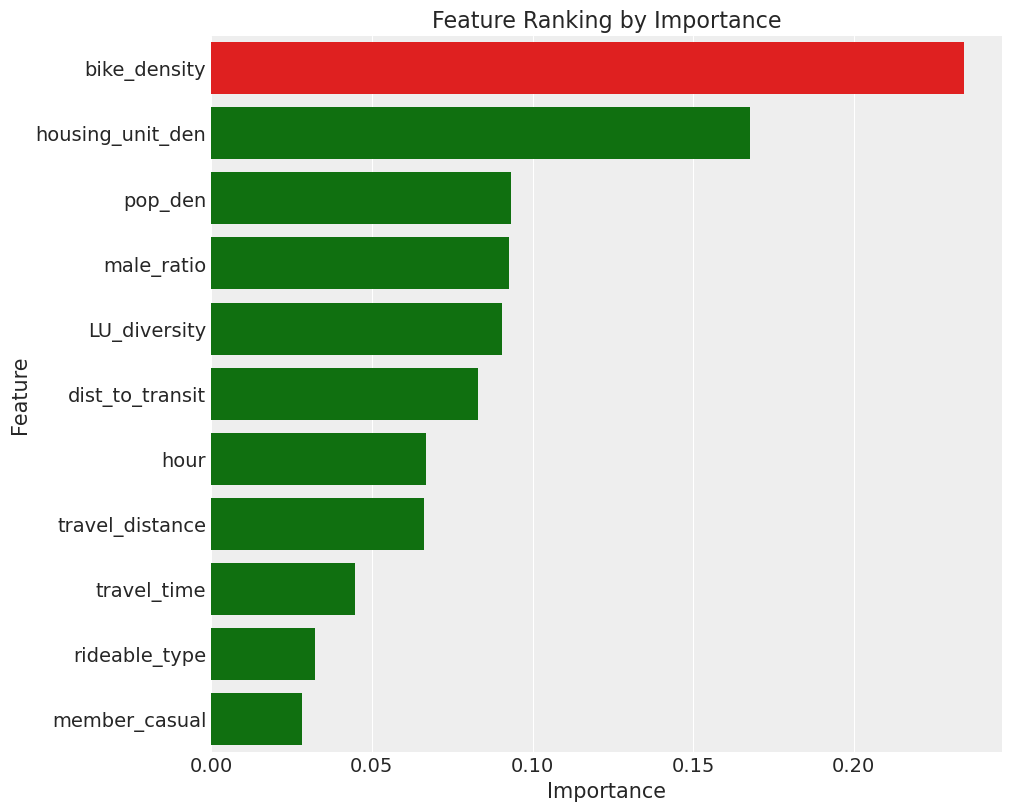

In [37]:
# Feature selection based on XGBoost
from xgboost import XGBRegressor
from xgboost import plot_importance

# fit model to training data
xgb_model = XGBRegressor(random_state = 100)
xgb_model.fit(X_train, y_train)

print("Feature Importances : ", xgb_model.feature_importances_)

'''
# plot feature importance
plot_importance(xgb_model)
plt.show()
'''

xgboost_idx = np.flip(np.argsort(xgb_model.feature_importances_))
xgboost_feature_plot = X_train.columns[xgboost_idx].to_numpy()
xgboost_importance_plot = xgb_model.feature_importances_[xgboost_idx]
df_feature_xgboost = pd.DataFrame({'Feature': xgboost_feature_plot,
                             'Importance': xgboost_importance_plot})

values = df_feature_xgboost.Importance.iloc[0:21]  
idx = df_feature_xgboost.Feature.iloc[0:21]  
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y = idx, x = values.astype('float'), palette = clrs).set(title = 'Feature Ranking by Importance')
plt.show()